<a href="https://colab.research.google.com/github/V4LM0R/E.C./blob/main/Bio_inspirado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Estructura del Notebook (para Colab)


In [ ]:
# @title Modelo de Abejas Recolectoras
# Importación de librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import random
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)
random.seed(42)

print("✓ Librerías cargadas exitosamente")

✓ Librerías cargadas exitosamente


## 2. Parámetros del Modelo

In [ ]:
class ParametrosAbejas:
    def __init__(self):
        self.tamaño_territorio = 30       # Tamaño del territorio (NxN)
        self.num_abejas = 50              # Número de abejas en la colonia
        self.num_flores = 100              # Número de flores en el territorio
        self.energia_inicial = 100        # Energía inicial de cada abeja
        self.umbral_explotacion = 0.7     # Umbral para cambiar de exploración a explotación
        self.tasa_deplecion = 0.1         # Tasa de reducción de néctar cuando es visitado
        self.tasa_recoleccion = 0.3       # Cantidad de néctar que recolecta una abeja por visita
        self.tasa_regeneracion = 0.02     # Tasa de regeneración de néctar en flores
        self.max_iteraciones = 500         # Máximo número de iteraciones
        self.radio_percepcion = 3         # Radio de percepción de las abejas

    def mostrar_parametros(self):
        print("📋 PARÁMETROS DEL MODELO DE ABEJAS")
        print(f"   • Tamaño del territorio: {self.tamaño_territorio}x{self.tamaño_territorio}")
        print(f"   • Número de abejas: {self.num_abejas}")
        print(f"   • Número de flores: {self.num_flores}")
        print(f"   • Radio de percepción: {self.radio_percepcion}")
        print(f"   • Umbral explotación: {self.umbral_explotacion*100:.1f}%")
        print(f"   • Máx. iteraciones: {self.max_iteraciones}")

# Crear instancia de parámetros
params_abejas = ParametrosAbejas()
params_abejas.mostrar_parametros()

📋 PARÁMETROS DEL MODELO
   • Tamaño de grilla: 20x20
   • Densidad poblacional: 85.0%
   • Proporción Grupo A: 50.0%
   • Proporción Grupo B: 50.0%
   • Umbral de felicidad: 30.0%
   • Máx. iteraciones: 200


## 3. Implementación del Modelo

In [ ]:
class ModeloAbejas:
    def __init__(self, parametros):
        self.params = parametros
        self.territorio = None
        self.abejas = []
        self.flores = []
        self.historial_recoleccion = []
        self.historial_exploracion = []
        self.iteracion_actual = 0

    def inicializar_ecosistema(self):
        """Inicializa el territorio con abejas y flores"""
        N = self.params.tamaño_territorio

        # Crear territorio vacío
        self.territorio = np.zeros((N, N))

        # Inicializar flores (cada flor tiene posición y cantidad de néctar)
        self.flores = []
        for _ in range(self.params.num_flores):
            x, y = random.randint(0, N-1), random.randint(0, N-1)
            nectar = random.uniform(0.5, 1.0)  # Néctar inicial aleatorio
            self.flores.append({'pos': (x, y), 'nectar': nectar, 'visitada': False})
            self.territorio[x, y] = 2  # Marcar flor en el territorio

        # Inicializar abejas (cada abeja tiene posición, energía y estado)
        self.abejas = []
        colmena_pos = (N//2, N//2)  # Colmena en el centro
        for _ in range(self.params.num_abejas):
            self.abejas.append({
                'pos': colmena_pos,
                'energia': self.params.energia_inicial,
                'estado': 'explorando',  # 'explorando' o 'explotando'
                'flor_objetivo': None,
                'memoria': []  # Flores descubiertas
            })
            self.territorio[colmena_pos] = 1  # Marcar colmena

    def obtener_flores_cercanas(self, pos):
        """Obtiene flores dentro del radio de percepción"""
        x, y = pos
        radio = self.params.radio_percepcion
        flores_cercanas = []

        for flor in self.flores:
            fx, fy = flor['pos']
            distancia = np.sqrt((fx - x)**2 + (fy - y)**2)
            if distancia <= radio:
                flores_cercanas.append(flor)

        return flores_cercanas

    def mover_abeja(self, abeja):
        """Mueve una abeja según su estado"""
        x, y = abeja['pos']
        N = self.params.tamaño_territorio

        if abeja['estado'] == 'explorando':
            # Movimiento aleatorio en exploración
            dx, dy = random.choice([(0,1), (1,0), (0,-1), (-1,0), (1,1), (-1,-1), (1,-1), (-1,1)])
            new_x, new_y = x + dx, y + dy

            # Mantener dentro del territorio
            new_x = max(0, min(N-1, new_x))
            new_y = max(0, min(N-1, new_y))

            abeja['pos'] = (new_x, new_y)
            abeja['energia'] -= 1  # Costo energético

            # Verificar si encuentra flores
            flores_cercanas = self.obtener_flores_cercanas(abeja['pos'])
            for flor in flores_cercanas:
                if flor not in abeja['memoria']:
                    abeja['memoria'].append(flor)

                    # Decidir si cambiar a explotación
                    if len(abeja['memoria']) / self.params.num_flores > self.params.umbral_explotacion:
                        abeja['estado'] = 'explotando'
                        abeja['flor_objetivo'] = max(abeja['memoria'], key=lambda f: f['nectar'])

        elif abeja['estado'] == 'explotando':
            # Movimiento hacia flor objetivo
            if abeja['flor_objetivo']:
                fx, fy = abeja['flor_objetivo']['pos']

                # Movimiento en dirección a la flor
                dx = 0 if x == fx else 1 if x < fx else -1
                dy = 0 if y == fy else 1 if y < fy else -1

                new_x, new_y = x + dx, y + dy
                abeja['pos'] = (new_x, new_y)
                abeja['energia'] -= 1

                # Si llegó a la flor, recolectar néctar
                if (new_x, new_y) == (fx, fy):
                    nectar_recolectado = abeja['flor_objetivo']['nectar'] * self.params.tasa_recoleccion
                    abeja['energia'] += nectar_recolectado * 10  # Convertir néctar en energía
                    abeja['flor_objetivo']['nectar'] *= (1 - self.params.tasa_deplecion)
                    abeja['flor_objetivo']['visitada'] = True

                    # Buscar nueva flor objetivo (la mejor en memoria)
                    if abeja['memoria']:
                        abeja['flor_objetivo'] = max(abeja['memoria'], key=lambda f: f['nectar'])

    def actualizar_flores(self):
        """Regenera néctar en las flores"""
        for flor in self.flores:
            flor['nectar'] = min(1.0, flor['nectar'] + self.params.tasa_regeneracion)
            flor['visitada'] = False

    def calcular_metricas(self):
        """Calcula métricas de recolección y exploración"""
        nectar_total = sum(f['nectar'] for f in self.flores)
        abejas_explorando = sum(1 for a in self.abejas if a['estado'] == 'explorando')
        proporcion_exploracion = abejas_explorando / len(self.abejas)

        return nectar_total, proporcion_exploracion

    def simular(self, mostrar_progreso=True):
        """Ejecuta la simulación completa"""
        print("🐝 Iniciando simulación del Modelo de Abejas...")

        # Inicializar ecosistema
        self.inicializar_ecosistema()

        # Calcular métricas iniciales
        nectar_inicial, exploracion_inicial = self.calcular_metricas()
        self.historial_recoleccion.append(nectar_inicial)
        self.historial_exploracion.append(exploracion_inicial)

        if mostrar_progreso:
            print(f"Estado inicial - Néctar total: {nectar_inicial:.1f}, Abejas explorando: {exploracion_inicial*100:.1f}%")

        # Ejecutar iteraciones
        for iteracion in range(self.params.max_iteraciones):
            self.iteracion_actual = iteracion + 1

            # Mover cada abeja
            for abeja in self.abejas:
                self.mover_abeja(abeja)

                # Si energía es crítica, volver a la colmena
                if abeja['energia'] < 20:
                    abeja['pos'] = (self.params.tamaño_territorio//2, self.params.tamaño_territorio//2)
                    abeja['energia'] = self.params.energia_inicial
                    abeja['estado'] = 'explorando'
                    abeja['flor_objetivo'] = None

            # Actualizar estado de las flores
            self.actualizar_flores()

            # Calcular métricas
            nectar, exploracion = self.calcular_metricas()
            self.historial_recoleccion.append(nectar)
            self.historial_exploracion.append(exploracion)

            # Mostrar progreso
            if mostrar_progreso and (iteracion + 1) % 50 == 0:
                print(f"Iteración {iteracion + 1:3d} - Néctar: {nectar:.1f}, Exploración: {exploracion*100:.1f}%")

        # Resumen final
        nectar_final, exploracion_final = self.calcular_metricas()
        print(f"\n📊 RESULTADOS FINALES:")
        print(f"   • Iteraciones ejecutadas: {self.iteracion_actual}")
        print(f"   • Néctar recolectado: {nectar_inicial - nectar_final:.1f} unidades")
        print(f"   • Abejas explorando al final: {exploracion_final*100:.1f}%")

✓ Clase ModeloSchelling implementada


## 4. Funciones de Visualización

In [ ]:
def visualizar_territorio(modelo, titulo="Estado de la Simulación"):
    """Visualiza el estado actual del territorio"""
    fig, ax = plt.subplots(figsize=(10, 10))
    N = modelo.params.tamaño_territorio

    # Crear matriz para visualización
    visual = np.zeros((N, N))

    # Marcar flores (intensidad según néctar disponible)
    for flor in modelo.flores:
        x, y = flor['pos']
        visual[x, y] = flor['nectar'] + 1  # Rango 1-2

    # Marcar abejas (3 para exploradoras, 4 para explotadoras)
    for abeja in modelo.abejas:
        x, y = abeja['pos']
        visual[x, y] = 3 if abeja['estado'] == 'explorando' else 4

    # Marcar colmena (centro)
    centro = N//2
    visual[centro, centro] = 5

    # Mostrar territorio
    cmap = plt.cm.get_cmap('viridis', 5)
    im = ax.imshow(visual, cmap=cmap, vmin=0, vmax=5)

    # Configuración
    ax.set_title(f"{titulo}\nIteración: {modelo.iteracion_actual}", fontsize=14)
    ax.set_xlabel("Coordenada X")
    ax.set_ylabel("Coordenada Y")

    # Leyenda
    from matplotlib.patches import Patch
    elementos = [
        Patch(facecolor='black', label='Vacío'),
        Patch(facecolor='yellow', label='Flor (poco néctar)'),
        Patch(facecolor='green', label='Flor (mucho néctar)'),
        Patch(facecolor='blue', label='Abeja exploradora'),
        Patch(facecolor='red', label='Abeja explotadora'),
        Patch(facecolor='brown', label='Colmena')
    ]
    ax.legend(handles=elementos, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def visualizar_evolucion(modelo):
    """Visualiza la evolución de las métricas"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    iteraciones = range(len(modelo.historial_recoleccion))

    # Gráfico de néctar
    ax1.plot(iteraciones, modelo.historial_recoleccion, color='green')
    ax1.set_title('Néctar Total en Flores', fontsize=14)
    ax1.set_xlabel('Iteración')
    ax1.set_ylabel('Néctar disponible')
    ax1.grid(True, alpha=0.3)

    # Gráfico de exploración
    ax2.plot(iteraciones, modelo.historial_exploracion, color='blue')
    ax2.set_title('Proporción de Abejas Exploradoras', fontsize=14)
    ax2.set_xlabel('Iteración')
    ax2.set_ylabel('Porcentaje explorando')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

✓ Funciones de visualización implementadas


## 5. Ejecución del Modelo


In [ ]:
# Crear y ejecutar modelo
print("🔬 EXPERIMENTO: Simulación de Abejas Recolectoras")
print("=" * 50)

modelo_abejas = ModeloAbejas(params_abejas)
modelo_abejas.simular()


🔬 EXPERIMENTO 1: Simulación Básica
🚀 Iniciando simulación del Modelo de Schelling...
✓ Población inicializada: 170 agentes tipo A, 170 agentes tipo B
Estado inicial - Felicidad: 0.809, Segregación: -0.026
Iteración  10 - Felicidad: 0.979, Segregación: 0.431
Iteración  20 - Felicidad: 0.994, Segregación: 0.499

✓ Convergencia alcanzada en iteración 22

📊 RESULTADOS FINALES:
   • Iteraciones ejecutadas: 22
   • Felicidad final: 1.000 (100.0%)
   • Índice de segregación: 0.507
   • Cambio en felicidad: +0.191
   • Cambio en segregación: +0.533

📊 Visualizando resultados...


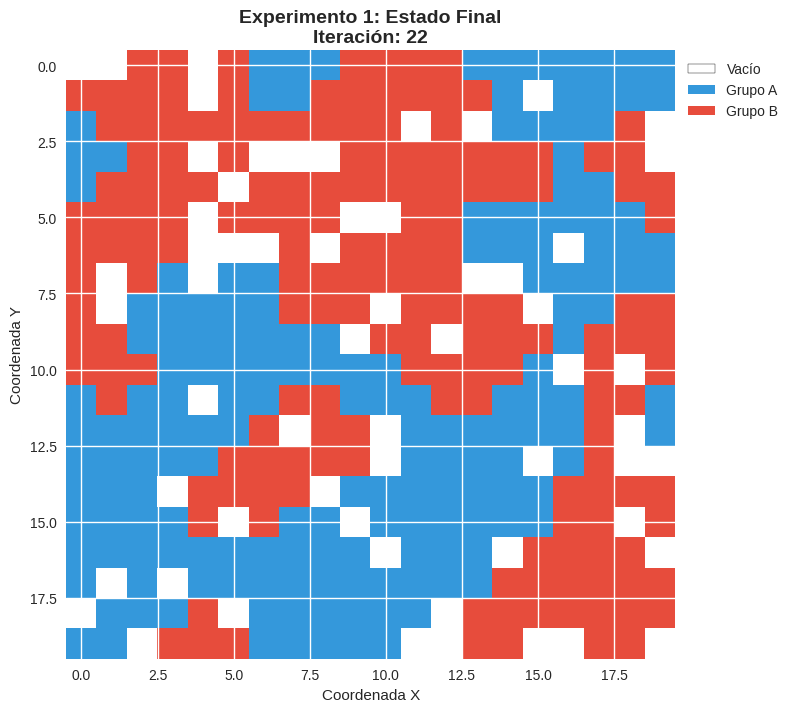

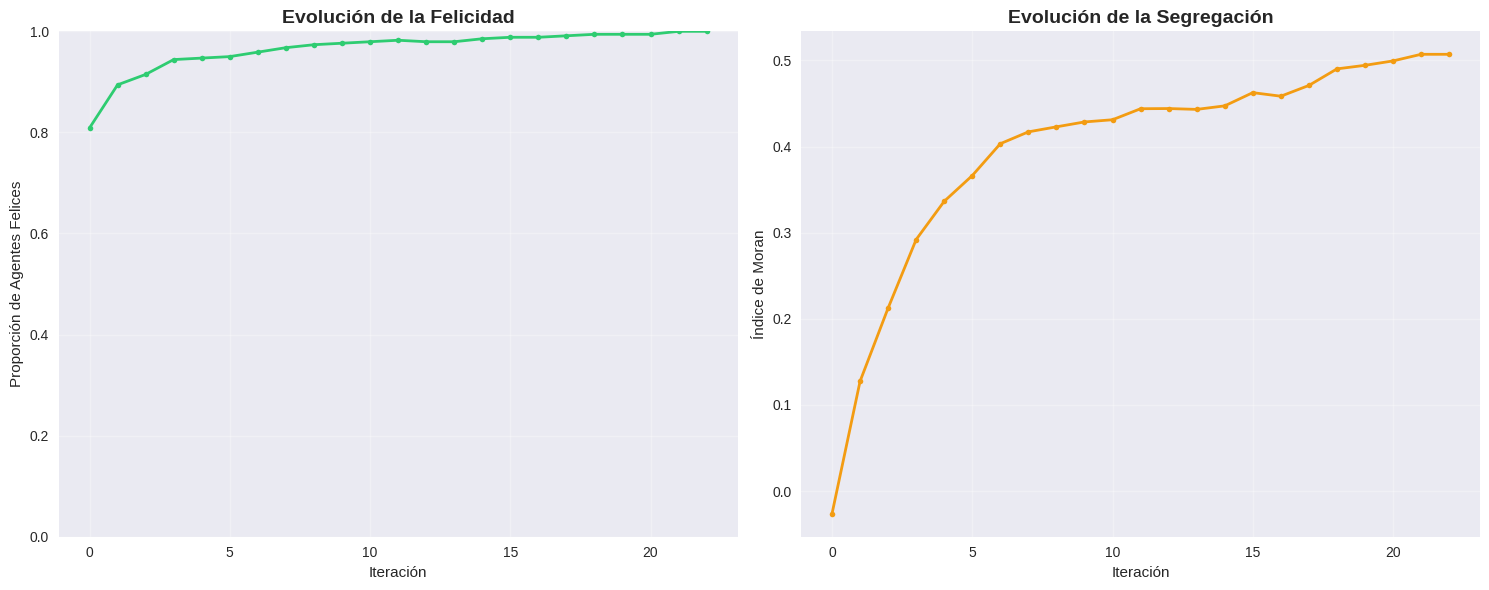

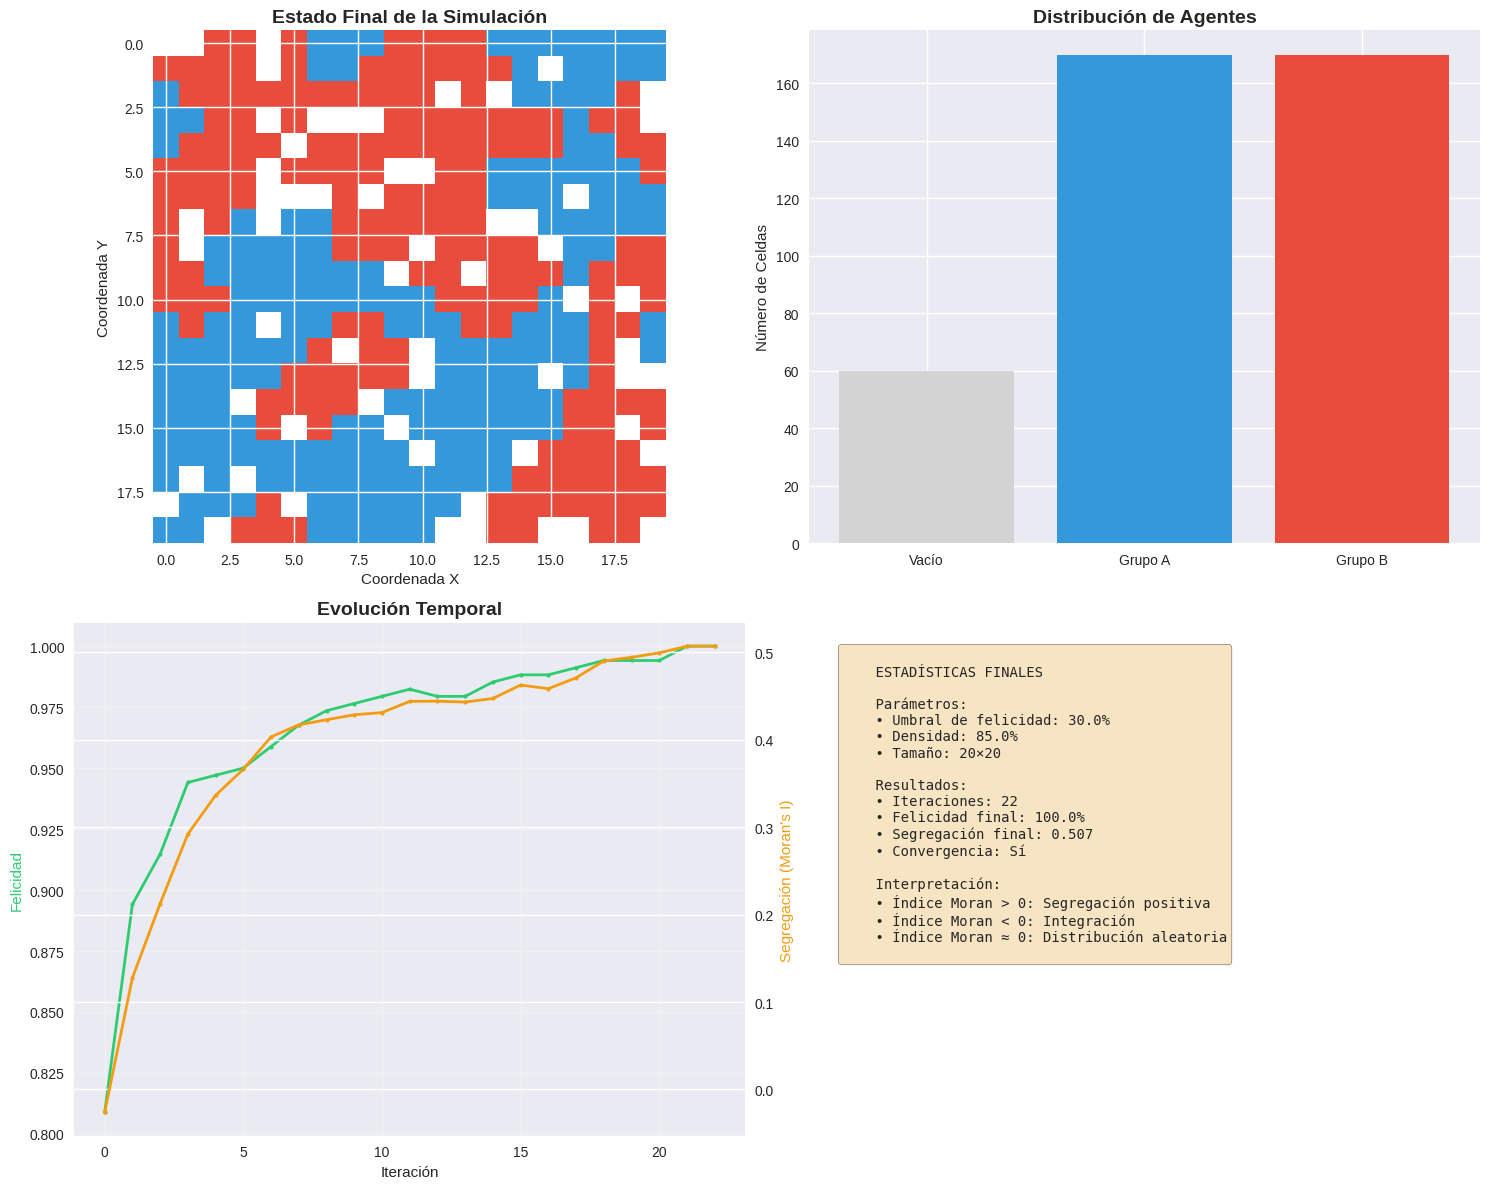

In [ ]:
# Visualizar resultados
print("\n📊 Visualizando resultados...")
visualizar_territorio(modelo_abejas, "Estado Final de la Simulación")
visualizar_evolucion(modelo_abejas)

## 5. Experimentos con Diferentes Parámetros

Exploramos cómo diferentes valores de umbral de felicidad afectan el resultado:

In [ ]:
print("🔬 EXPERIMENTO 2: Variación del Umbral de Felicidad")
print("=" * 60)

# Diferentes umbrales a probar
umbrales = [0.1, 0.3, 0.5, 0.7]
resultados_umbrales = []

for umbral in umbrales:
    print(f"\n🧪 Probando umbral: {umbral*100:.0f}%")

    # Crear parámetros modificados
    params_temp = ParametrosSchelling()
    params_temp.umbral_felicidad = umbral
    params_temp.tamaño_grilla = 30  # Reducir tamaño para rapidez

    # Ejecutar simulación
    modelo_temp = ModeloSchelling(params_temp)
    modelo_temp.simular(mostrar_progreso=False)

    # Guardar resultados
    resultado = {
        'umbral': umbral,
        'iteraciones': modelo_temp.iteracion_actual,
        'felicidad_final': modelo_temp.historial_felicidad[-1],
        'segregacion_final': modelo_temp.historial_segregacion[-1],
        'convergencia': modelo_temp.convergencia_alcanzada
    }
    resultados_umbrales.append(resultado)

    print(f"   ✓ Resultado: {resultado['felicidad_final']*100:.1f}% felicidad, "
          f"segregación {resultado['segregacion_final']:.3f}")

# Crear DataFrame para análisis
df_umbrales = pd.DataFrame(resultados_umbrales)
print("\n📊 Resumen de resultados:")
print(df_umbrales.round(3))

🔬 EXPERIMENTO 2: Variación del Umbral de Felicidad

🧪 Probando umbral: 10%
🚀 Iniciando simulación del Modelo de Schelling...
✓ Población inicializada: 382 agentes tipo A, 383 agentes tipo B

✓ Convergencia alcanzada en iteración 5

📊 RESULTADOS FINALES:
   • Iteraciones ejecutadas: 5
   • Felicidad final: 1.000 (100.0%)
   • Índice de segregación: 0.012
   • Cambio en felicidad: +0.013
   • Cambio en segregación: +0.017
   ✓ Resultado: 100.0% felicidad, segregación 0.012

🧪 Probando umbral: 30%
🚀 Iniciando simulación del Modelo de Schelling...
✓ Población inicializada: 382 agentes tipo A, 383 agentes tipo B

✓ Convergencia alcanzada en iteración 15

📊 RESULTADOS FINALES:
   • Iteraciones ejecutadas: 15
   • Felicidad final: 1.000 (100.0%)
   • Índice de segregación: 0.428
   • Cambio en felicidad: +0.187
   • Cambio en segregación: +0.435
   ✓ Resultado: 100.0% felicidad, segregación 0.428

🧪 Probando umbral: 50%
🚀 Iniciando simulación del Modelo de Schelling...
✓ Población inicializad

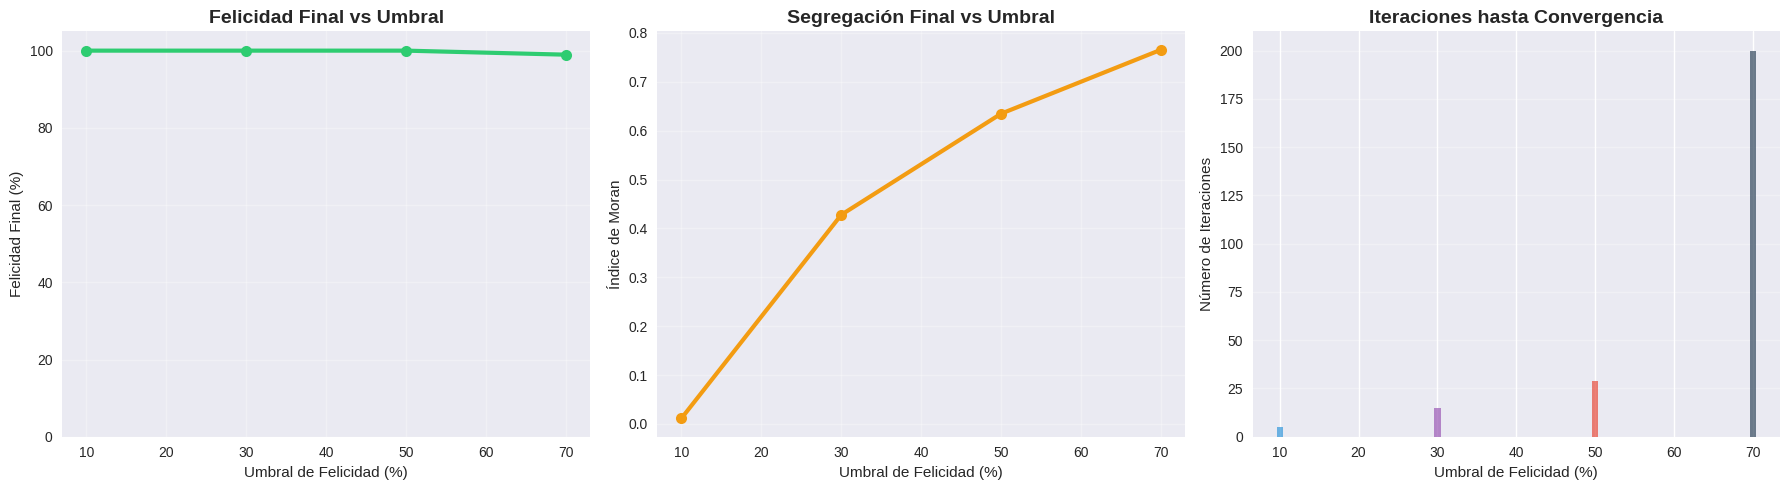


🔍 ANÁLISIS DE CORRELACIONES:
   • Correlación Umbral-Segregación: 0.967
   • Correlación Umbral-Felicidad: -0.775
   ✓ Se confirma: umbrales más altos → mayor segregación


In [ ]:
# Visualizar resultados del experimento de umbrales
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de felicidad vs umbral
ax1.plot(df_umbrales['umbral'] * 100, df_umbrales['felicidad_final'] * 100,
         'o-', color='#2ecc71', linewidth=3, markersize=8)
ax1.set_title('Felicidad Final vs Umbral', fontsize=14, fontweight='bold')
ax1.set_xlabel('Umbral de Felicidad (%)')
ax1.set_ylabel('Felicidad Final (%)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# Gráfico de segregación vs umbral
ax2.plot(df_umbrales['umbral'] * 100, df_umbrales['segregacion_final'],
         'o-', color='#f39c12', linewidth=3, markersize=8)
ax2.set_title('Segregación Final vs Umbral', fontsize=14, fontweight='bold')
ax2.set_xlabel('Umbral de Felicidad (%)')
ax2.set_ylabel('Índice de Moran')
ax2.grid(True, alpha=0.3)

# Gráfico de iteraciones vs umbral
ax3.bar(df_umbrales['umbral'] * 100, df_umbrales['iteraciones'],
        color=['#3498db', '#9b59b6', '#e74c3c', '#34495e'], alpha=0.7)
ax3.set_title('Iteraciones hasta Convergencia', fontsize=14, fontweight='bold')
ax3.set_xlabel('Umbral de Felicidad (%)')
ax3.set_ylabel('Número de Iteraciones')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Análisis de correlaciones
print("\n🔍 ANÁLISIS DE CORRELACIONES:")
correlacion_umbral_segregacion = df_umbrales['umbral'].corr(df_umbrales['segregacion_final'])
correlacion_umbral_felicidad = df_umbrales['umbral'].corr(df_umbrales['felicidad_final'])

print(f"   • Correlación Umbral-Segregación: {correlacion_umbral_segregacion:.3f}")
print(f"   • Correlación Umbral-Felicidad: {correlacion_umbral_felicidad:.3f}")

if correlacion_umbral_segregacion > 0.7:
    print("   ✓ Se confirma: umbrales más altos → mayor segregación")
elif correlacion_umbral_segregacion < -0.7:
    print("   ✓ Se observa: umbrales más altos → menor segregación")
else:
    print("   ⚠ Relación no lineal clara entre umbral y segregación")

## 6. Análisis Teórico y Discusión

### Interpretación de Resultados

Los experimentos nos permiten observar varios fenómenos importantes:

1. **Emergencia de Segregación**: Incluso con preferencias moderadas (umbral 30%), pueden surgir patrones de segregación significativa.

2. **Relación No Lineal**: La relación entre umbral individual y segregación global no es siempre lineal.

3. **Convergencia**: El sistema tiende a estabilizarse, pero el tiempo puede variar significativamente.

### Aplicaciones en el Mundo Real

Este modelo tiene aplicaciones en:
- **Planificación urbana**: Entender patrones residenciales
- **Políticas públicas**: Diseñar intervenciones para promover integración
- **Sociología**: Explicar dinámicas de grupos sociales
- **Economía**: Modelar mercados segmentados

In [ ]:
def experimento_personalizado(tamaño=40, densidad=0.8, umbral=0.4, proporcion=0.5):
    """Permite al usuario ejecutar experimentos con parámetros personalizados"""
    print(f"🧪 EXPERIMENTO PERSONALIZADO")
    print(f"   • Tamaño: {tamaño}×{tamaño}")
    print(f"   • Densidad: {densidad*100:.1f}%")
    print(f"   • Umbral: {umbral*100:.1f}%")
    print(f"   • Proporción Grupo A: {proporcion*100:.1f}%")
    print("=" * 50)

    # Crear parámetros personalizados
    params_custom = ParametrosSchelling()
    params_custom.tamaño_grilla = tamaño
    params_custom.densidad = densidad
    params_custom.umbral_felicidad = umbral
    params_custom.proporcion_grupo1 = proporcion

    # Ejecutar simulación
    modelo_custom = ModeloSchelling(params_custom)
    modelo_custom.simular()

    return modelo_custom

# Ejemplo de uso (los estudiantes pueden modificar estos valores)
print("\n💡 EXPERIMENTA CON DIFERENTES PARÁMETROS:")
print("Modifica los valores abajo para explorar diferentes escenarios\n")

# Experimento con alta tolerancia
modelo_tolerante = experimento_personalizado(tamaño=35, densidad=0.9, umbral=0.2, proporcion=0.5)


💡 EXPERIMENTA CON DIFERENTES PARÁMETROS:
Modifica los valores abajo para explorar diferentes escenarios

🧪 EXPERIMENTO PERSONALIZADO
   • Tamaño: 35×35
   • Densidad: 90.0%
   • Umbral: 20.0%
   • Proporción Grupo A: 50.0%
🚀 Iniciando simulación del Modelo de Schelling...
✓ Población inicializada: 551 agentes tipo A, 551 agentes tipo B
Estado inicial - Felicidad: 0.941, Segregación: 0.025

✓ Convergencia alcanzada en iteración 8

📊 RESULTADOS FINALES:
   • Iteraciones ejecutadas: 8
   • Felicidad final: 1.000 (100.0%)
   • Índice de segregación: 0.195
   • Cambio en felicidad: +0.059
   • Cambio en segregación: +0.171


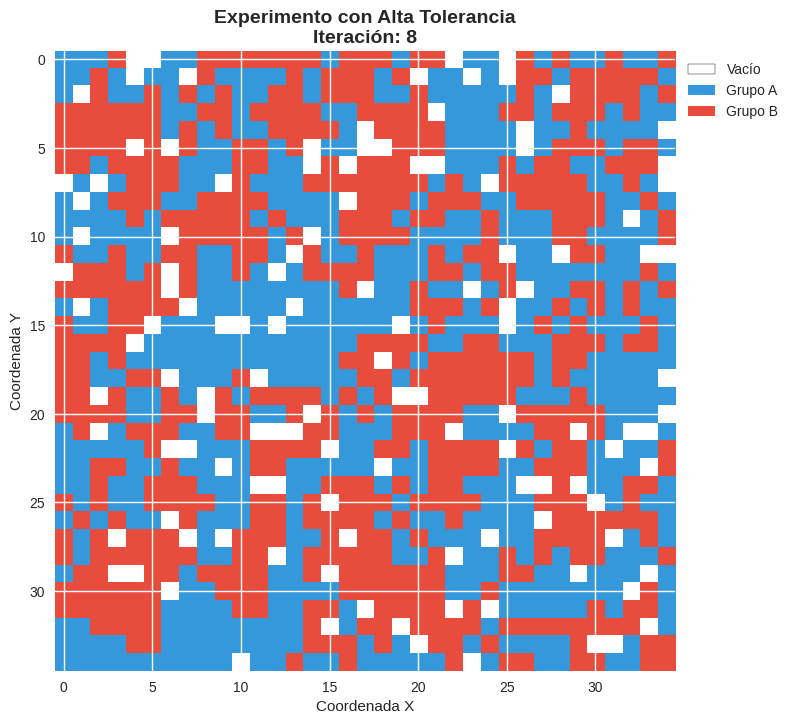

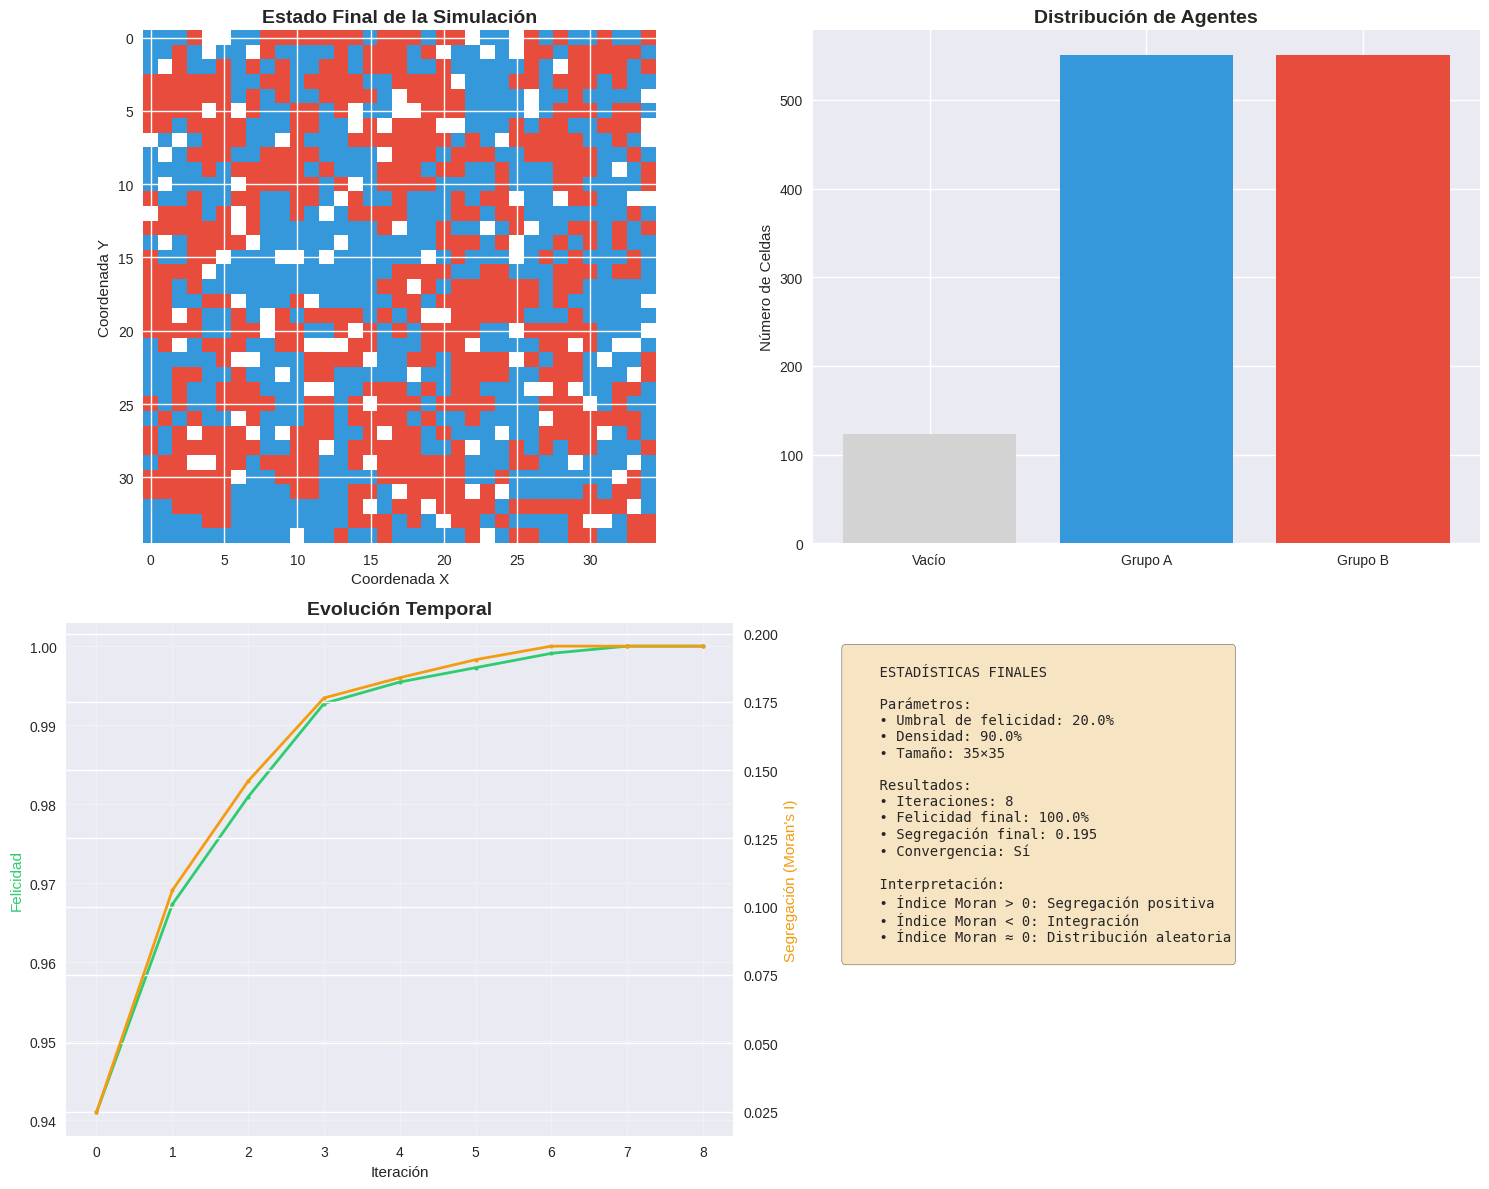

In [ ]:
# Visualizar experimento personalizado
visualizar_grilla(modelo_tolerante, "Experimento con Alta Tolerancia")
comparar_estados(modelo_tolerante)

## 7. Ejercicios

### Ejercicio 1: Análisis de Sensibilidad
Ejecuta simulaciones con diferentes combinaciones de parámetros y analiza:
- ¿Cómo afecta la densidad poblacional a la segregación?
- ¿Qué pasa si un grupo es mucho más pequeño que el otro?
- ¿Existe un umbral crítico donde la segregación cambia dramáticamente?

### Ejercicio 2: Modificaciones del Modelo
Considera estas extensiones:
- **Tres grupos**: ¿Cómo cambia la dinámica con más diversidad?
- **Diferentes umbrales**: ¿Qué pasa si cada grupo tiene preferencias distintas?
- **Restricciones espaciales**: ¿Cómo afectan barreras geográficas?

### Ejercicio 3: Interpretación Sociológica
- Conecta los resultados con fenómenos reales de segregación urbana
- Discute las limitaciones del modelo
- Propón políticas que podrían promover mayor integración

### Ejercicio 4: Análisis Estadístico
- Ejecuta múltiples simulaciones y calcula estadísticas descriptivas
- Realiza pruebas de hipótesis sobre el efecto de diferentes parámetros
- Construye intervalos de confianza para las métricas de segregación

In [ ]:
# PLANTILLA PARA EJERCICIOS
# Copia y modifica este código para tus experimentos

def mi_experimento():
    """Plantilla para que los estudiantes implementen sus propios experimentos"""

    # TODO: Definir parámetros de tu experimento
    mis_parametros = ParametrosSchelling()
    mis_parametros.tamaño_grilla = 30     # Modifica aquí
    mis_parametros.densidad = 0.7         # Modifica aquí
    mis_parametros.umbral_felicidad = 0.3 # Modifica aquí
    mis_parametros.proporcion_grupo1 = 0.5 # Modifica aquí

    # TODO: Ejecutar simulación
    mi_modelo = ModeloSchelling(mis_parametros)
    mi_modelo.simular()

    # TODO: Visualizar resultados
    visualizar_grilla(mi_modelo, "Mi Experimento")
    visualizar_evolucion(mi_modelo)

    # TODO: Analizar y reportar tus hallazgos
    print("\n📝 MIS HALLAZGOS:")
    print("   • [Escribe aquí tus observaciones]")
    print("   • [¿Qué patrones observas?]")
    print("   • [¿Cómo se relaciona con la teoría?]")

    return mi_modelo

# Descomenta la siguiente línea para ejecutar tu experimento
# mi_modelo = mi_experimento()